# Finding Metro Sales Price Trends

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
from fbprophet import Prophet
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters


In [2]:
nbhd_ts = pd.read_csv("./../src/data/raw/NeighborhoodMedianRent.csv")
N = 5
nbhd_ts

,RegionName,City,State,Metro,CountyName,SizeRank,2010-02,2010-03,2010-04,2010-05,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,Northeast Dallas,Dallas,TX,Dallas-Fort Worth-Arlington,Dallas County,1,NaN,NaN,NaN,NaN,...,1.488095,1.479730,1.488813,1.589396,1.584565,1.753273,1.526000,1.493103,1.571429,1.559934
1,Maryvale,Phoenix,AZ,Phoenix-Mesa-Scottsdale,Maricopa County,2,NaN,NaN,NaN,NaN,...,0.942105,1.003861,1.032468,1.052165,1.041667,1.103819,1.153207,1.200515,1.224593,1.242604
2,Paradise,Las Vegas,NV,Las Vegas-Henderson-Paradise,Clark County,3,NaN,NaN,NaN,NaN,...,1.246692,1.270958,1.270508,1.362365,1.316919,1.336284,1.301870,1.291759,1.289869,1.266449
3,Upper West Side,New York,NY,New York-Newark-Jersey City,New York County,4,NaN,NaN,NaN,NaN,...,5.177521,5.144000,5.193797,5.254902,5.247581,5.317510,5.250000,5.321222,5.286078,5.458705
4,Upper East Side,New York,NY,New York-Newark-Jersey City,New York County,5,NaN,NaN,NaN,NaN,...,4.923338,4.960235,4.955471,5.000000,5.032823,5.137097,5.045872,5.000000,5.028951,5.081744
5,Sunrise Manor,Las Vegas,NV,Las Vegas-Henderson-Paradise,Clark County,6,NaN,NaN,NaN,NaN,...,0.953984,0.965430,1.001890,1.010376,1.005464,1.020408,1.044399,1.015532,1.012801,1.025520
6,Spring Valley,Las Vegas,NV,Las Vegas-Henderson-Paradise,Clark County,7,NaN,NaN,NaN,NaN,...,1.243352,1.258273,1.246954,1.252000,1.275113,1.282339,1.292699,1.290294,1.274101,1.290043
7,Paradise Valley,Phoenix,AZ,Phoenix-Mesa-Scottsdale,Maricopa County,8,NaN,NaN,NaN,NaN,...,1.367662,1.394826,1.412873,1.414375,1.412873,1.424329,1.402439,1.425550,1.419753,1.385468
8,Deer Valley,Phoenix,AZ,Phoenix-Mesa-Scottsdale,Maricopa County,9,NaN,NaN,NaN,NaN,...,1.158859,1.190470,1.204974,1.236345,1.244156,1.255471,1.264970,1.290173,1.286765,1.288671
9,North Mountain,Phoenix,AZ,Phoenix-Mesa-Scottsdale,Maricopa County,10,NaN,NaN,NaN,NaN,...,1.112108,1.157426,1.161866,1.178612,1.204506,1.231795,1.233672,1.256897,1.241325,1.242605


In [3]:
sf_nbhd_ts = nbhd_ts[nbhd_ts.Metro == "San Francisco-Oakland-Hayward"]
sf_nbhd_ts.head()
nbhd_datasets = {}
for nbhd_str in list(sf_nbhd_ts["RegionName"]): #Get neighborhood string
    #Get sample data with NY into right shape
    ppsq = sf_nbhd_ts[sf_nbhd_ts.RegionName == nbhd_str].iloc[[0],6:]
    ds = ppsq.columns
    ppsq = ppsq.T
    ds = pd.to_datetime(ds, infer_datetime_format = True)
    ppsq["ds"] = ds
    print(ppsq)
    ppsq.columns = ["y","ds"]
    ppsq = ppsq.query("y.notnull()")
    nbhd_datasets[nbhd_str] = ppsq.copy()
    print(f"{nbhd_str}\n{ppsq}\n")
nbhd_datasets.keys()

              188         ds
2010-02       NaN 2010-02-01
2010-03       NaN 2010-03-01
2010-04       NaN 2010-04-01
2010-05       NaN 2010-05-01
2010-06       NaN 2010-06-01
...           ...        ...
2019-06  4.727899 2019-06-01
2019-07  4.887077 2019-07-01
2019-08  4.964146 2019-08-01
2019-09  4.875784 2019-09-01
2019-10  4.975124 2019-10-01

[117 rows x 2 columns]
Mission
                y         ds
2013-11  4.211248 2013-11-01
2013-12  4.318182 2013-12-01
2014-01  4.340278 2014-01-01
2014-02  4.329230 2014-02-01
2014-03  4.318182 2014-03-01
...           ...        ...
2019-06  4.727899 2019-06-01
2019-07  4.887077 2019-07-01
2019-08  4.964146 2019-08-01
2019-09  4.875784 2019-09-01
2019-10  4.975124 2019-10-01

[72 rows x 2 columns]

              264         ds
2010-02       NaN 2010-02-01
2010-03       NaN 2010-03-01
2010-04       NaN 2010-04-01
2010-05       NaN 2010-05-01
2010-06       NaN 2010-06-01
...           ...        ...
2019-06  3.453336 2019-06-01
2019-07  3.55102


              527         ds
2010-02       NaN 2010-02-01
2010-03       NaN 2010-03-01
2010-04       NaN 2010-04-01
2010-05       NaN 2010-05-01
2010-06       NaN 2010-06-01
...           ...        ...
2019-06  5.413105 2019-06-01
2019-07  6.000000 2019-07-01
2019-08  6.393980 2019-08-01
2019-09  6.779859 2019-09-01
2019-10  6.627172 2019-10-01

[117 rows x 2 columns]
Nob Hill
                y         ds
2016-12  5.084746 2016-12-01
2017-01  5.241690 2017-01-01
2017-02  4.932152 2017-02-01
2017-03  4.933399 2017-03-01
2017-04  4.991635 2017-04-01
2017-05  4.833333 2017-05-01
2017-06  4.929577 2017-06-01
2017-07  5.158333 2017-07-01
2017-08  4.993750 2017-08-01
2017-09  4.996429 2017-09-01
2017-10  4.666667 2017-10-01
2017-11  4.646176 2017-11-01
2017-12  4.895833 2017-12-01
2018-01  4.718182 2018-01-01
2018-02  4.477307 2018-02-01
2018-03  4.629630 2018-03-01
2018-04  4.666667 2018-04-01
2018-05  5.037488 2018-05-01
2018-06  5.215054 2018-06-01
2018-07  5.389255 2018-07-01
2018-08  

[117 rows x 2 columns]
Downtown
                y         ds
2012-06  1.817980 2012-06-01
2012-07  1.890049 2012-07-01
2012-08  1.872807 2012-08-01
2012-09  1.932222 2012-09-01
2012-10  2.035760 2012-10-01
...           ...        ...
2019-06  3.052402 2019-06-01
2019-07  2.981195 2019-07-01
2019-08  2.890515 2019-08-01
2019-09  2.853118 2019-09-01
2019-10  2.930385 2019-10-01

[89 rows x 2 columns]

              818         ds
2010-02       NaN 2010-02-01
2010-03       NaN 2010-03-01
2010-04       NaN 2010-04-01
2010-05       NaN 2010-05-01
2010-06       NaN 2010-06-01
...           ...        ...
2019-06  2.724771 2019-06-01
2019-07  2.885375 2019-07-01
2019-08  2.759336 2019-08-01
2019-09  2.730795 2019-09-01
2019-10  2.598411 2019-10-01

[117 rows x 2 columns]
Mission-Garin
                y         ds
2017-11  2.649611 2017-11-01
2017-12  2.667984 2017-12-01
2018-01  2.491139 2018-01-01
2018-02  2.490814 2018-02-01
2018-03  2.544474 2018-03-01
2018-04  2.484211 2018-04-01
2018-05


             1258         ds
2010-02       NaN 2010-02-01
2010-03       NaN 2010-03-01
2010-04       NaN 2010-04-01
2010-05       NaN 2010-05-01
2010-06       NaN 2010-06-01
...           ...        ...
2019-06  5.968468 2019-06-01
2019-07  6.045328 2019-07-01
2019-08  5.666667 2019-08-01
2019-09  5.715615 2019-09-01
2019-10  5.633333 2019-10-01

[117 rows x 2 columns]
Telegraph Hill
                y         ds
2017-03  4.692605 2017-03-01
2017-04  5.484625 2017-04-01
2017-05  5.246914 2017-05-01
2017-06  4.821429 2017-06-01
2017-07  5.454545 2017-07-01
2017-08  4.861449 2017-08-01
2017-09  5.198777 2017-09-01
2017-10  5.198777 2017-10-01
2017-11  5.404951 2017-11-01
2017-12  5.592114 2017-12-01
2018-01  5.600000 2018-01-01
2018-02  5.477273 2018-02-01
2018-03  5.595000 2018-03-01
2018-04  5.582524 2018-04-01
2018-05  5.078396 2018-05-01
2018-06  4.682622 2018-06-01
2018-07  5.437500 2018-07-01
2018-08  5.600000 2018-08-01
2018-09  5.331078 2018-09-01
2018-10  5.331078 2018-10-01
201


             1392         ds
2010-02       NaN 2010-02-01
2010-03       NaN 2010-03-01
2010-04       NaN 2010-04-01
2010-05       NaN 2010-05-01
2010-06       NaN 2010-06-01
...           ...        ...
2019-06  4.594111 2019-06-01
2019-07  4.373878 2019-07-01
2019-08  4.374625 2019-08-01
2019-09  4.337658 2019-09-01
2019-10  4.363257 2019-10-01

[117 rows x 2 columns]
Bay Meadows
                y         ds
2018-03  4.045735 2018-03-01
2018-04  4.125000 2018-04-01
2018-05  4.316971 2018-05-01
2018-06  4.328230 2018-06-01
2018-07  4.325233 2018-07-01
2018-08  4.331678 2018-08-01
2018-09  4.242704 2018-09-01
2018-10  4.279376 2018-10-01
2018-11  4.232603 2018-11-01
2018-12  4.335941 2018-12-01
2019-01  4.355203 2019-01-01
2019-02  4.374074 2019-02-01
2019-03  4.469846 2019-03-01
2019-04  4.557740 2019-04-01
2019-05  4.615007 2019-05-01
2019-06  4.594111 2019-06-01
2019-07  4.373878 2019-07-01
2019-08  4.374625 2019-08-01
2019-09  4.337658 2019-09-01
2019-10  4.363257 2019-10-01

     

dict_keys(['Mission', 'Outer Richmond', 'Inner Richmond', 'South of Market', 'Pacific Heights', 'Tenderloin', 'West End', 'Downtown', 'Centerville', 'Nob Hill', 'Western Addition', 'Noe Valley', 'Russian Hill', 'Inner Sunset', 'Marina', 'Redwood Shores', 'Mission-Garin', 'Mission-Foothill', 'Mission Bay', 'Cherry-Guardino', 'Lower Pacific Heights', 'Downtown Berkeley', 'South Beach', 'Telegraph Hill', 'Financial District', 'Los Prados', 'San Pablo Gateway', 'Produce & Waterfront', 'Ellinwood', 'Marina Bay', 'Bay Meadows', 'Bair Island', 'Four Corners', 'Pilgrim-Triton'])

In [ ]:
# get some prophet going
from pmdarima.arima import auto_arima
from datetime import timedelta
pd.plotting.register_matplotlib_converters()
pos = 0
fig, axs = plt.subplots(17, 2,figsize=(500,300))
alex =0

preds = {}
for (city_str, city_prices) in nbhd_datasets.items():
    city_prices.set_index('ds', inplace=True)
    stepwise_model = auto_arima(city_prices, error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    stepwise_model.fit(city_prices)
    future_forecast = stepwise_model.predict(n_periods=12)
    last_date = city_prices.index[-1]
    numberOfDates = []
    for x in range(12):
        last_date = last_date + timedelta(days=30)
        numberOfDates.append(last_date)

    forecast = pd.DataFrame(future_forecast,index = numberOfDates,columns=['Prediction'])
    
    forecast.index = pd.to_datetime(forecast.index,infer_datetime_format=True)
    forecast.index.name= 'ds'
    forecast['dates'] = pd.to_datetime(forecast.index)
    forecast = forecast.rename(columns={"Prediction": "y"})
    city_prices.index = pd.to_datetime(city_prices.index,infer_datetime_format=True)
    city_prices['dates'] = pd.to_datetime(city_prices.index)

#     city_prices.plot(x = 'dates', y= 'y')
#     forecast.plot(x = 'dates', y = 'y')
    plt.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    preds[city_str] = forecast, city_prices
#     plt.show()
    total = pd.concat([forecast,city_prices])
#     total.plot(x = 'dates', y= 'y')
#     plt.show()
    if alex ==0:
        fig = axs[pos,alex].plot(total['dates'], total['y'])
        alex+=1
    else:
        fig = axs[pos,alex].plot(total['dates'], total['y'])
        pos += 1
        alex=0



    
#     machine_learning = Prophet(yearly_seasonality = True,weekly_seasonality=False,daily_seasonality=False, seasonality_prior_scale=0.1)
#     machine_learning.fit(city_prices)
#     future = machine_learning.make_future_dataframe(periods=60, freq = 'm')
#     prediction = machine_learning.predict(future)
#     preds[city_str] = prediction, machine_learning




In [ ]:
fig = plt.figure(facecolor='w', figsize=(15,len(preds)*2), dpi=300)
ax = None
pos = 1
for (city, (p,m)) in preds.items():
    if ax is not None:
        ax = fig.add_subplot((len(preds)/2 + 1), 2, pos, xlabel="Year", ylabel="Median Price Per Square Foot", sharex = ax, sharey = ax, title = city)
        #ax = fig.add_subplot(ax)
    else:
        ax = fig.add_subplot((len(preds)/2 + 1), 2, pos, title = city)
        #ax = fig.add_subplot(1,1, 1, xlabel="Year", ylabel="Median Home Price", )
    pos += 1
    fig = m.plot(p, xlabel = "Year", ylabel = "Median Price Per Square Foot ($)", ax=ax)

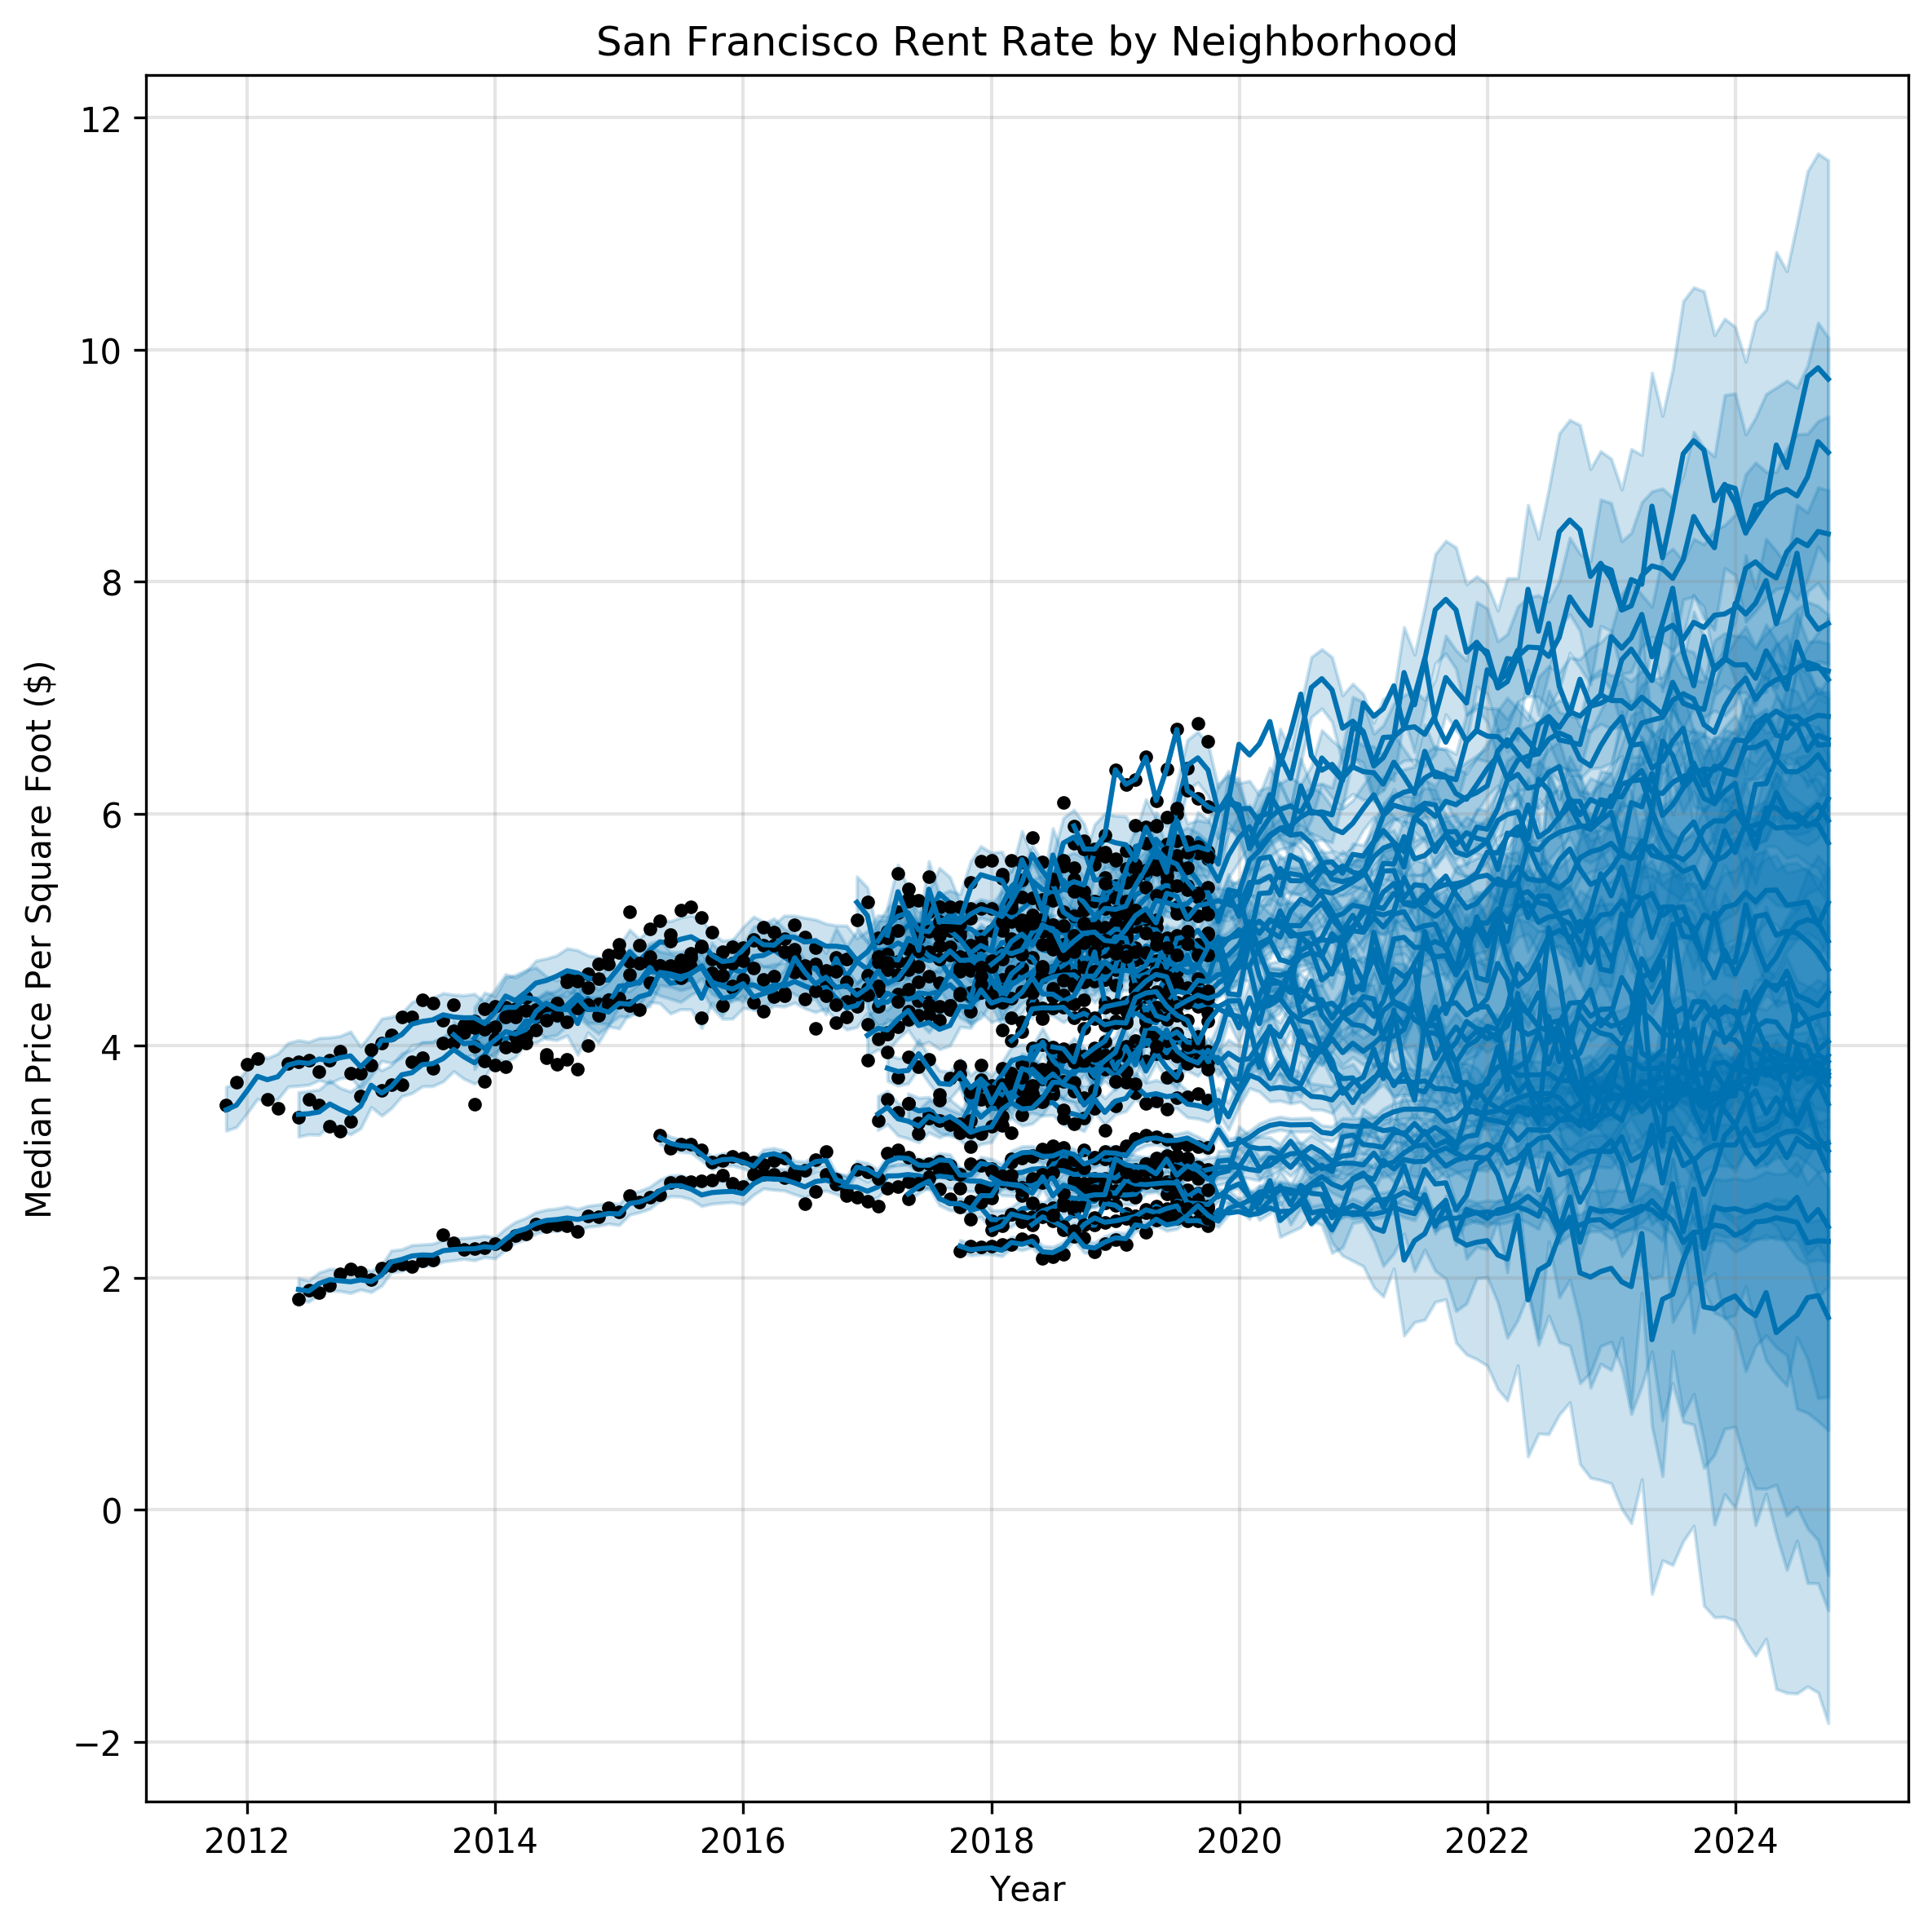

In [6]:
fig2 = plt.figure(facecolor='w', figsize=(8,8), dpi=300)
ax2 = None
for (city, (p,m)) in preds.items():
    if city == "Tenderloin":
        continue
    if ax2 is not None:
        ax2 = fig2.add_subplot(ax2)
    else:
        ax2 = fig2.add_subplot(1,1, 1, title="San Francisco Rent Rate by Neighborhood")
    pos += 1
    fig2 = m.plot(p, xlabel = "Year", ylabel = "Median Price Per Square Foot ($)", ax=ax2)

In [7]:
#fig.savefig("/Users/potter/Pictures/ind_neighborhood_forecasts.png", transparent=True, dpi=300, format="png")
#fig2.savefig("/Users/potter/Pictures/all_neighborhood_forecasts_outlier_removed.png", transparent=True, dpi=300, format="png")


Nob Hill
Russian Hill
Telegraph Hill
Financial District
San Pablo Gateway
Produce & Waterfront
Bair Island


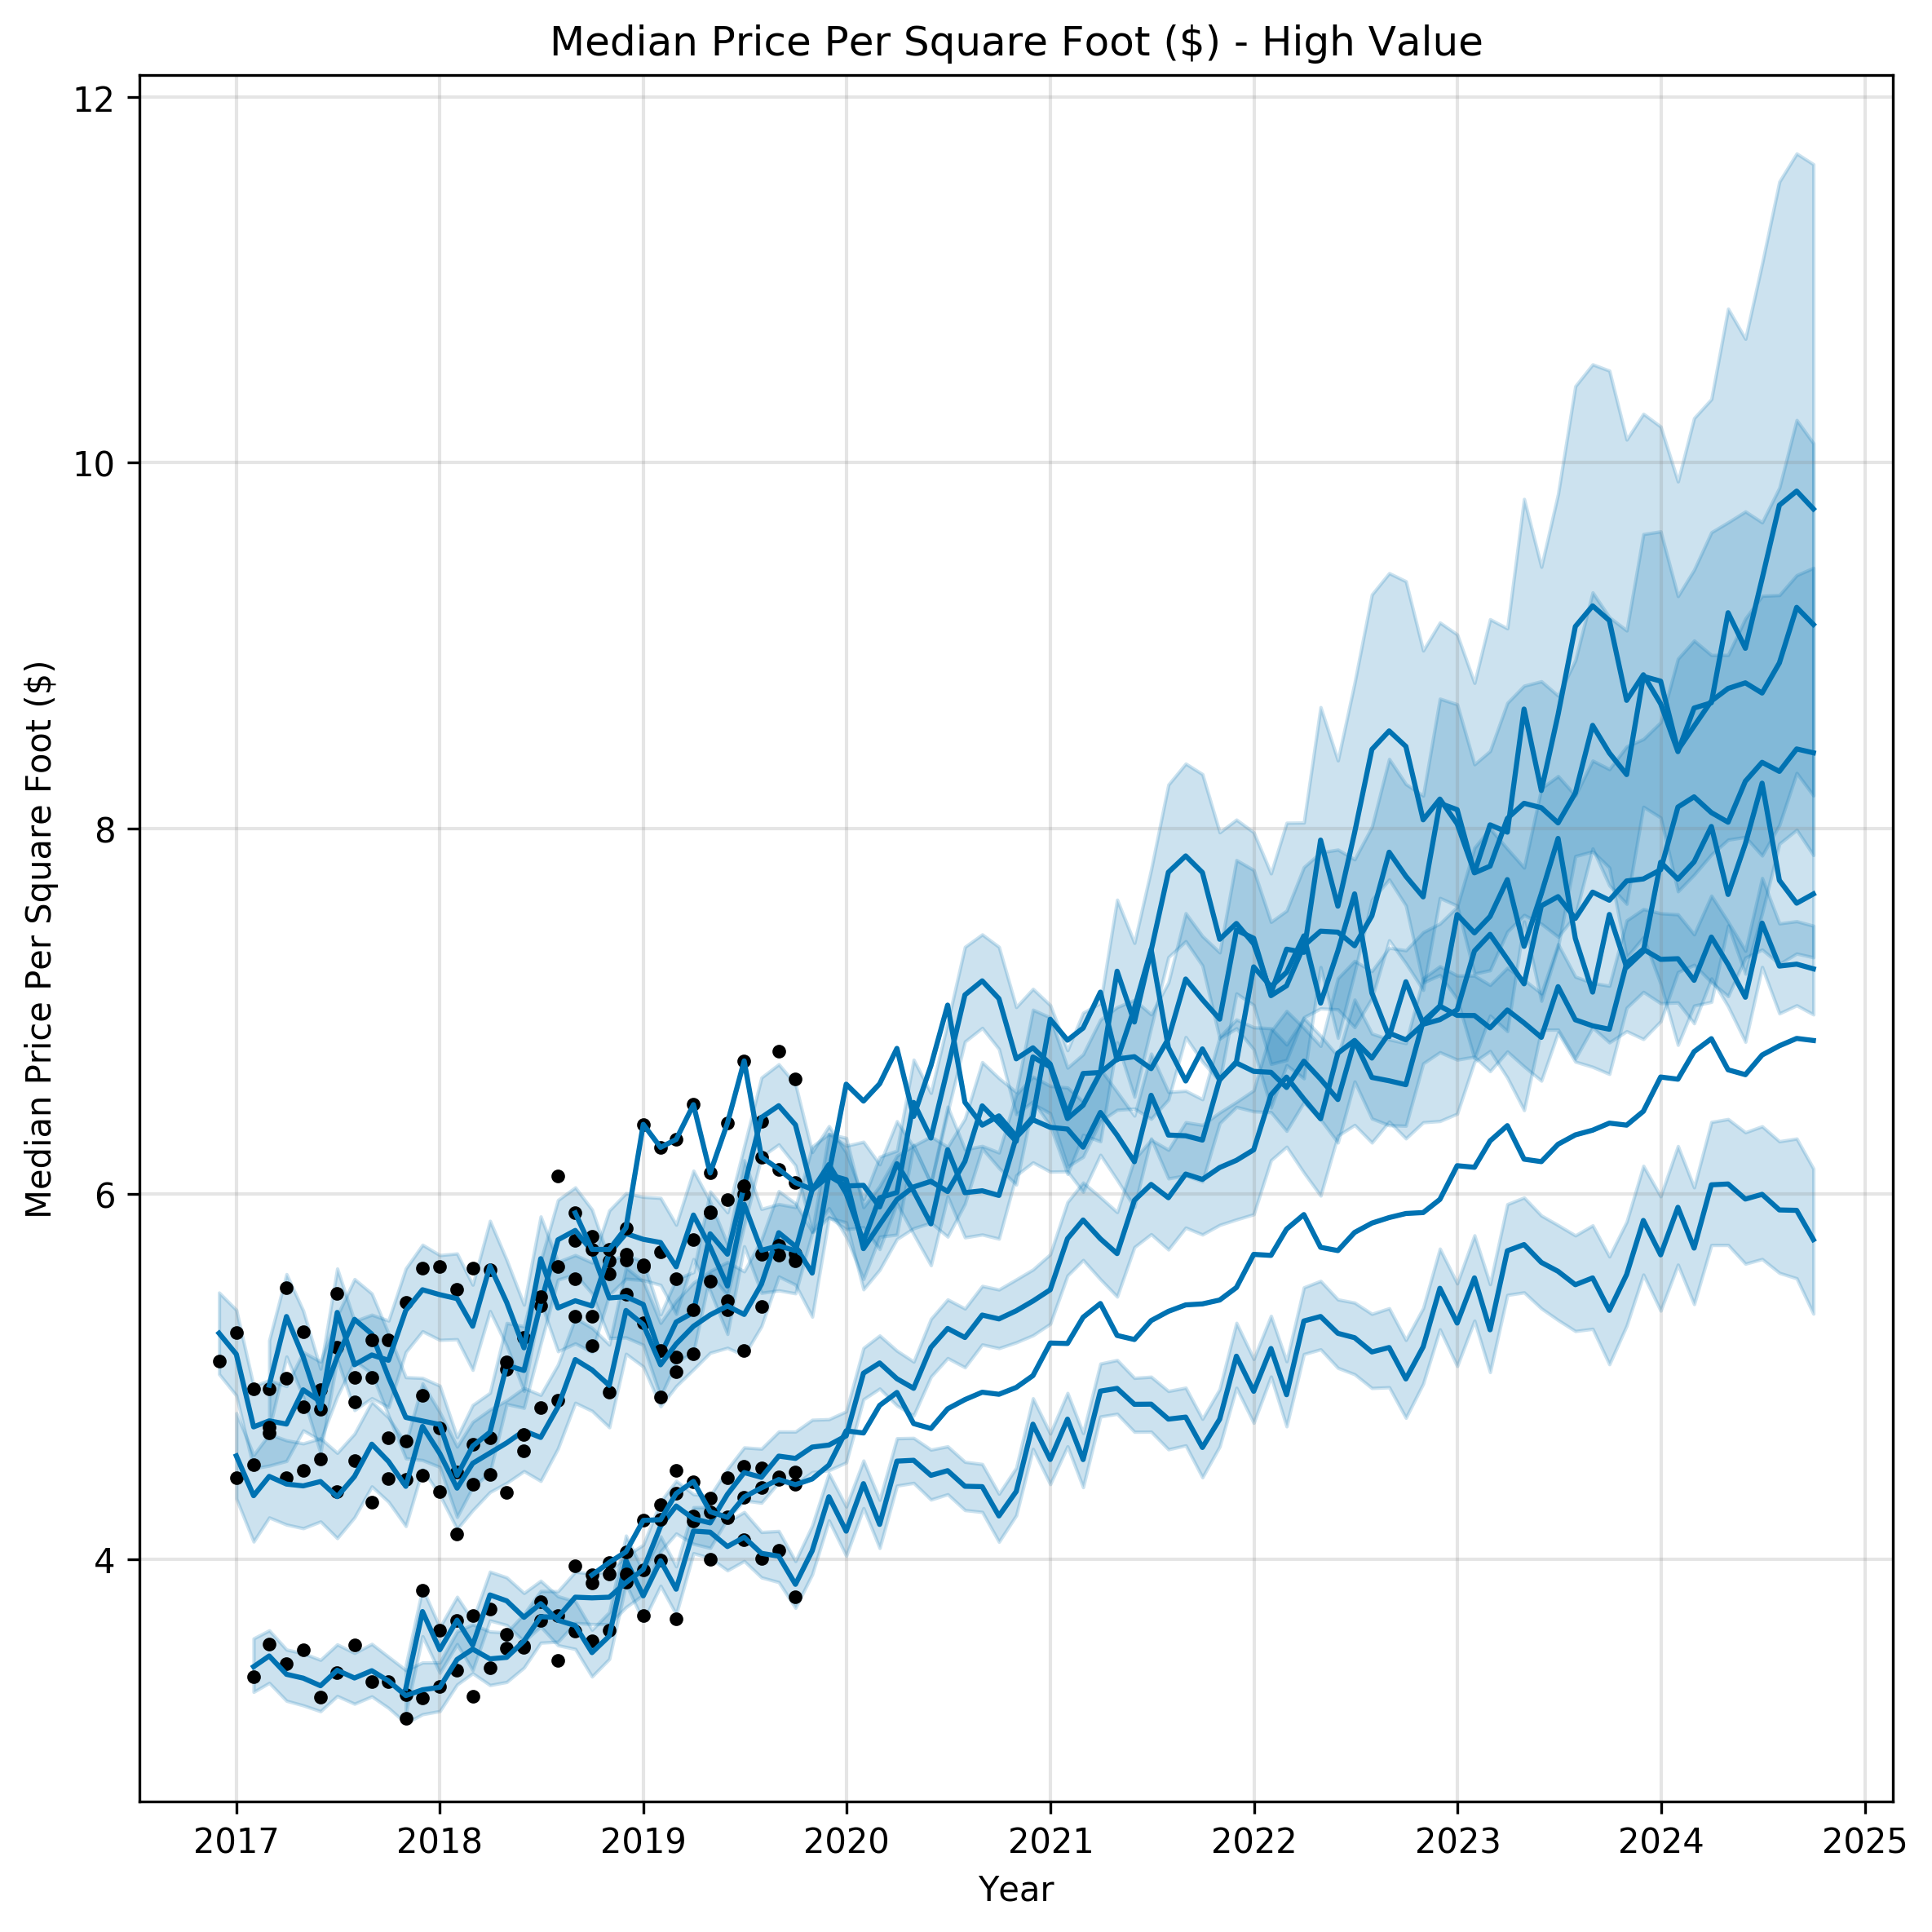

In [8]:
fig3 = plt.figure(facecolor='w', figsize=(8,8), dpi=300)
ax3 = None
for (city, (p,m)) in preds.items():
    if p[p.ds == "2024-09-30"].iloc[0].at['yhat'] - p[p.ds == "2019-09-01"].iloc[0].at['yhat'] > 1.5:
        if city == "Tenderloin":
            continue
        elif ax3 is not None:
            ax3 = fig3.add_subplot(ax3)
        else:
            ax3 = fig3.add_subplot(1,1, 1, title="Median Price Per Square Foot ($) - High Value")
        pos += 1
        fig3 = m.plot(p, xlabel = "Year", ylabel = "Median Price Per Square Foot ($)", ax=ax3)
        print(city)

In [9]:
#fig3.savefig("/Users/potter/Pictures/high_neighborhood_forecasts.png", transparent=True, dpi=300, format="png")


In [10]:
data = []
for (city, (p,m)) in preds.items():
    v_19 = p[p.ds == "2019-09-01"].iloc[0].at['yhat']
    v_25 = p[p.ds == "2024-09-30"].iloc[0].at['yhat']
    delta_p =  v_25 - v_19 
    data.append({"neighborhood":city, "2019_val": v_19, "2025_val": v_25,
                 "delta": delta_p, "percent_change": delta_p/v_19})
    
nbhd_predictions = pd.DataFrame(data)

In [22]:
districts =[
    ["Inner Richmond", "Central Richmond", "Outer Richmond", "Vista del Mar", "Lone Mountain",
       "Golden Gate Park", "Lincoln Park", "University of San Francisco", "Farallon Islands"],
    ["Marina", "Cow Hollow", "Pacific Heights", "Seacliff", "Lake District", "Presidio Heights", 
       "Jordan Park", "Laurel Heights", "Presidio", "Russian Hill"],
    ["North Beach", "Chinatown", "Telegraph Hill", "North Waterfront", "Financial District", 
        "Nob Hill", "Union Square", "Maiden Lane"],
    ["Central Sunset", 'Outer Sunset', 'Parkside', 'Outer Parkside', 'Pine Lake Park'],
    ['Inner Sunset', 'Haight Ashbury', 'Lower Haight', 'Fillmore', 'Western Addition',
        'Cathedral Hill', 'Parnassus Heights', 'North Panhandle', 'Anza Vista', 'Lower Pacific Heights',
        'Japantown', 'Hayes Valley', 'Ashbury Heights', 'UCSF Parnassus Heights'],
    ['Union Square', 'Tenderloin', 'Civic Center', 'Mid-Market', 'Cathedral Hill', 
         'South of Market', 'South Beach', 'Mission Bay', 'Treasure Island', 'Yerba Buena Island', 'Alcatraz'],
    ['Inner Parkside', 'Golden Gate Heights', 'Clarendon Heights', 'Twin Peaks', 'West Portal', 'Forest Knolls',
        'Midtown Terrace', 'Forest Hill', 'Miraloma Park', 'Sunnyside', 'Sherwood Forest', 'Westwood Highlands', 'Westwood Park',
        'St. Francis Wood', 'Monterey Heights', 'Mt. Davidson', 'Balboa Terrace', 'Ingleside Terrace', 'Stonestown', 'Lakeside', 
        'Lake Shore', 'Merced Manor', 'Parkmerced', 'Lake Merced', 'City College', 
        'San Francisco State', 'Ashbury Heights', 'UCSF Parnassus Heights'],
    ['Downtown','The Castro', 'Noe Valley', 'Diamond Heights', 'Glen Park', 'Corona Heights', 'Eureka Valley', 'Dolores Heights',
       'Mission Dolores', 'Duboce Triangle', 'Buena Vista Park', 'Twin Peaks'],
    ['Mission', 'Bernal Heights', 'Portola'],
    ['Potrero Hill', 'Central Waterfront', 'Dogpatch', 'Bayview-Hunters Point', 'Bayview Heights',
       'India Basin', 'Silver Terrace', 'Candlestick Point', 'Visitacion Valley', 'Little Hollywood',
       'Sunnydale', 'McLaren Park'],
['Excelsior', 'Ingleside', 'Oceanview', 'Merced Heights', 'Ingleside Heights', 'Mission Terrace',
        'Outer Mission', 'Cayuga', 'Crocker Amazon']
]
nbhd_dist = {'Russian Hill':'3','Tenderloin':'6','Outer Sunset': '4', 'Mission': '9', 'Outer Richmond': '1', 'Inner Richmond': '1',
       'Parkside': '4', 'South of Market': '6', 'Excelsior': '11', 'Pacific Heights': '2',
       'Bernal Heights': '9', 'Nob Hill': '3', 'Portola': '9', 'Western Addition': '5',
       'Bayview': '10', 'Potrero Hill': '10', 'Noe Valley': '8', 'Inner Sunset': '5',
       'Visitacion Valley': '10', 'Crocker Amazon': '11', 'Golden Gate Heights': '7',
       'Marina': '2', 'Ingleside': '11', 'Mission Terrace': '11', 'Silver Terrace': '10',
       'Oceanview': '11', 'North Beach': '3', 'Lone Mountain': '1', 'Sunnyside': '7',
       'Outer Mission': '11', 'Panhandle': '5', 'Buena Vista': '8', 'Ingleside Heights': '11',
       'Lower Pacific Heights': '5', 'South Beach': '6', 'Haight': '5',
       'Presidio Heights': '2', 'Laurel Heights': '2', 'Hayes Valley': '5',
       'Upper Market': '6', 'Miraloma Park': '7', 'Lakeshore': '7', 'Cow Hollow': '2',
       'Glen Park': '8', 'Telegraph Hill': '3', 'Lake': '2', 'Downtown': '3',
       'Diamond Heights': '8', 'Stonestown': '7', 'Westwood Park': '7',
       'Ingleside Terrace': '7', 'Forest Hill': '7', 'Corona Heights': '8',
       'Midtown Terrace':'7', 'Little Hollywood':'10', 'North Waterfront': '3',
       'Forest Knolls': '7', 'Seacliff': '2', 'St. Francis Wood':'7',
       'Mount Davidson Manor': '7', 'Westwood Highlands': '7', "Mission Bay":'6', 'Financial District':'3',
        'Marina Bay':'7'}

for i, lst in enumerate(districts):
    for n in lst:
        nbhd_dist[n] = str(i+1)
print(nbhd_dist)
nbhd_predictions["district"] = nbhd_predictions["neighborhood"].map(nbhd_dist)
nbhd_predictions

{'Russian Hill': '2', 'Tenderloin': '6', 'Outer Sunset': '4', 'Mission': '9', 'Outer Richmond': '1', 'Inner Richmond': '1', 'Parkside': '4', 'South of Market': '6', 'Excelsior': '11', 'Pacific Heights': '2', 'Bernal Heights': '9', 'Nob Hill': '3', 'Portola': '9', 'Western Addition': '5', 'Bayview': '10', 'Potrero Hill': '10', 'Noe Valley': '8', 'Inner Sunset': '5', 'Visitacion Valley': '10', 'Crocker Amazon': '11', 'Golden Gate Heights': '7', 'Marina': '2', 'Ingleside': '11', 'Mission Terrace': '11', 'Silver Terrace': '10', 'Oceanview': '11', 'North Beach': '3', 'Lone Mountain': '1', 'Sunnyside': '7', 'Outer Mission': '11', 'Panhandle': '5', 'Buena Vista': '8', 'Ingleside Heights': '11', 'Lower Pacific Heights': '5', 'South Beach': '6', 'Haight': '5', 'Presidio Heights': '2', 'Laurel Heights': '2', 'Hayes Valley': '5', 'Upper Market': '6', 'Miraloma Park': '7', 'Lakeshore': '7', 'Cow Hollow': '2', 'Glen Park': '8', 'Telegraph Hill': '3', 'Lake': '2', 'Downtown': '8', 'Diamond Heights':

,neighborhood,2019_val,2025_val,delta,percent_change,district
0,Mission,4.716224,5.232122,0.515898,0.109388,9
1,Outer Richmond,3.483845,3.783275,0.299430,0.085948,1
2,Inner Richmond,4.047703,3.498264,-0.549439,-0.135741,1
3,South of Market,5.659413,7.157028,1.497615,0.264624,6
4,Pacific Heights,4.994989,5.941853,0.946864,0.189563,2
5,Tenderloin,5.801762,9.048442,3.246680,0.559602,6
6,West End,2.956255,1.657224,-1.299031,-0.439418,NaN
7,Downtown,2.914943,3.164598,0.249654,0.085646,8
8,Centerville,3.158750,3.736358,0.577608,0.182860,NaN
9,Nob Hill,6.481813,9.747710,3.265897,0.503856,3


In [25]:
nbhd_predictions_clean = nbhd_predictions.query("district.notnull()")
nbhd_predictions_clean

,neighborhood,2019_val,2025_val,delta,percent_change,district
0,Mission,4.716224,5.232122,0.515898,0.109388,9
1,Outer Richmond,3.483845,3.783275,0.299430,0.085948,1
2,Inner Richmond,4.047703,3.498264,-0.549439,-0.135741,1
3,South of Market,5.659413,7.157028,1.497615,0.264624,6
4,Pacific Heights,4.994989,5.941853,0.946864,0.189563,2
5,Tenderloin,5.801762,9.048442,3.246680,0.559602,6
7,Downtown,2.914943,3.164598,0.249654,0.085646,8
9,Nob Hill,6.481813,9.747710,3.265897,0.503856,3
10,Western Addition,4.855727,4.036687,-0.819040,-0.168675,5
11,Noe Valley,4.537192,3.094335,-1.442858,-0.318007,8
